In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [3, 3]

In [1]:
#https://avandekleut.github.io/vae/
#https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

In [2]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

In [3]:
LATENT_DIMS = 2
BATCH_SIZE = 128

In [4]:

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=BATCH_SIZE,
        shuffle=True)

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.tanh(self.linear1(x))

        # q(z/x) ~ N(mu,exp(log_var) * I)
        mu =  self.linear2(x)
        log_var = self.linear3(x)

        return mu,log_var

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.tanh(self.linear1(z))

        # sigmoid because output values are normalized in range [0-1]
        x = torch.sigmoid(self.linear2(z))
        return x.reshape((-1, 1, 28, 28))

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda(2) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda(2)

        self.kl = 0.0
        self.recon_loss = 0.0
    
    def reparametrize(self,mu,log_var):
        sigma = torch.exp(0.5*log_var)
        z = mu + sigma*self.N.sample(mu.shape)
        return z
    
    def forward(self, x):

        # Bernoulli MLP
        z_mu,z_log_var = self.encoder(x)
        z_sigma = torch.exp(0.5*z_log_var)
        z = z_mu + z_sigma*self.N.sample(z_mu.shape)
        #z = self.reparametrize(z_mu,z_log_var)
        self.KL = 0.5 * torch.sum(z_log_var.exp() + z_mu.pow(2) - z_log_var - 1) / BATCH_SIZE

        x_hat = self.decoder(z)
        self.recon_loss = -F.binary_cross_entropy(x_hat, x, reduction='sum') / BATCH_SIZE


        # Guassian MLP
        # x_mu,x_log_var = self.decoder(z)
        # x_sigma = torch.exp(0.5*x_log_var)
        # distributions = torch.distributions.MultivariateNormal(x_mu, torch.diag_embed(x_sigma))

        # # Calculate log probability of x
        # log_probs = distributions.log_prob(x.reshape(x.shape[0],784))
        # self.recon_loss = log_probs.sum() / BATCH_SIZE
        # x_hat = x_mu + x_sigma*self.N.sample(x_mu.shape)
        return x_hat.reshape((-1,1,28,28))

In [11]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr= 1e-3)
    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)

            ELBO = autoencoder.recon_loss - autoencoder.kl
            loss = -ELBO
            total_loss +=loss
            loss.backward()
            
            opt.step()
        if epoch%5 == 0:
            print("Epoch == ",epoch,"  Loss == ",total_loss.item()/len(data))
    return autoencoder

In [12]:
vae = VariationalAutoencoder(LATENT_DIMS).to(device) # GPU
vae = train(vae, data, epochs = 50)

Epoch ==  0   Loss ==  178.999483608742
Epoch ==  5   Loss ==  147.34060167910448
Epoch ==  10   Loss ==  142.25314832089552
Epoch ==  15   Loss ==  139.39838752665244
Epoch ==  20   Loss ==  137.53797974413646
Epoch ==  25   Loss ==  136.2362989738806
Epoch ==  30   Loss ==  135.22167344083155
Epoch ==  35   Loss ==  134.30135594349682
Epoch ==  40   Loss ==  133.56314132462686
Epoch ==  45   Loss ==  132.8735174573561


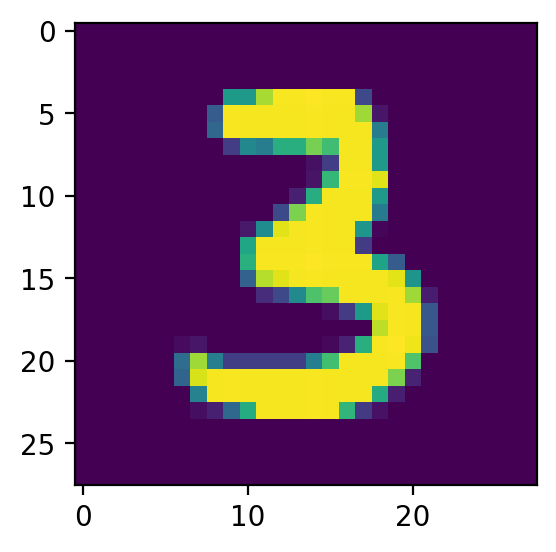

In [83]:
images, targets = next(iter(data))
img = images[10]
plt.imshow(img.reshape(28,28))

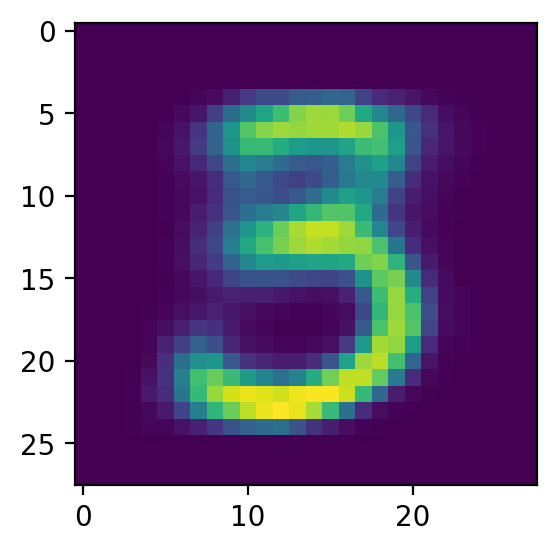

In [84]:
recon = vae(img.to(device).reshape(1,1,28,28))
plt.imshow(recon.cpu().detach().numpy().reshape(28,28))

In [112]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z_mu, z_log_var = autoencoder.encoder(x.to(device))
        #z = autoencoder.reparametrize(z_mu,z_log_var)
        z_sigma = torch.exp(0.5*z_log_var)
        z = z_mu + z_sigma*autoencoder.N.sample(z_mu.shape)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

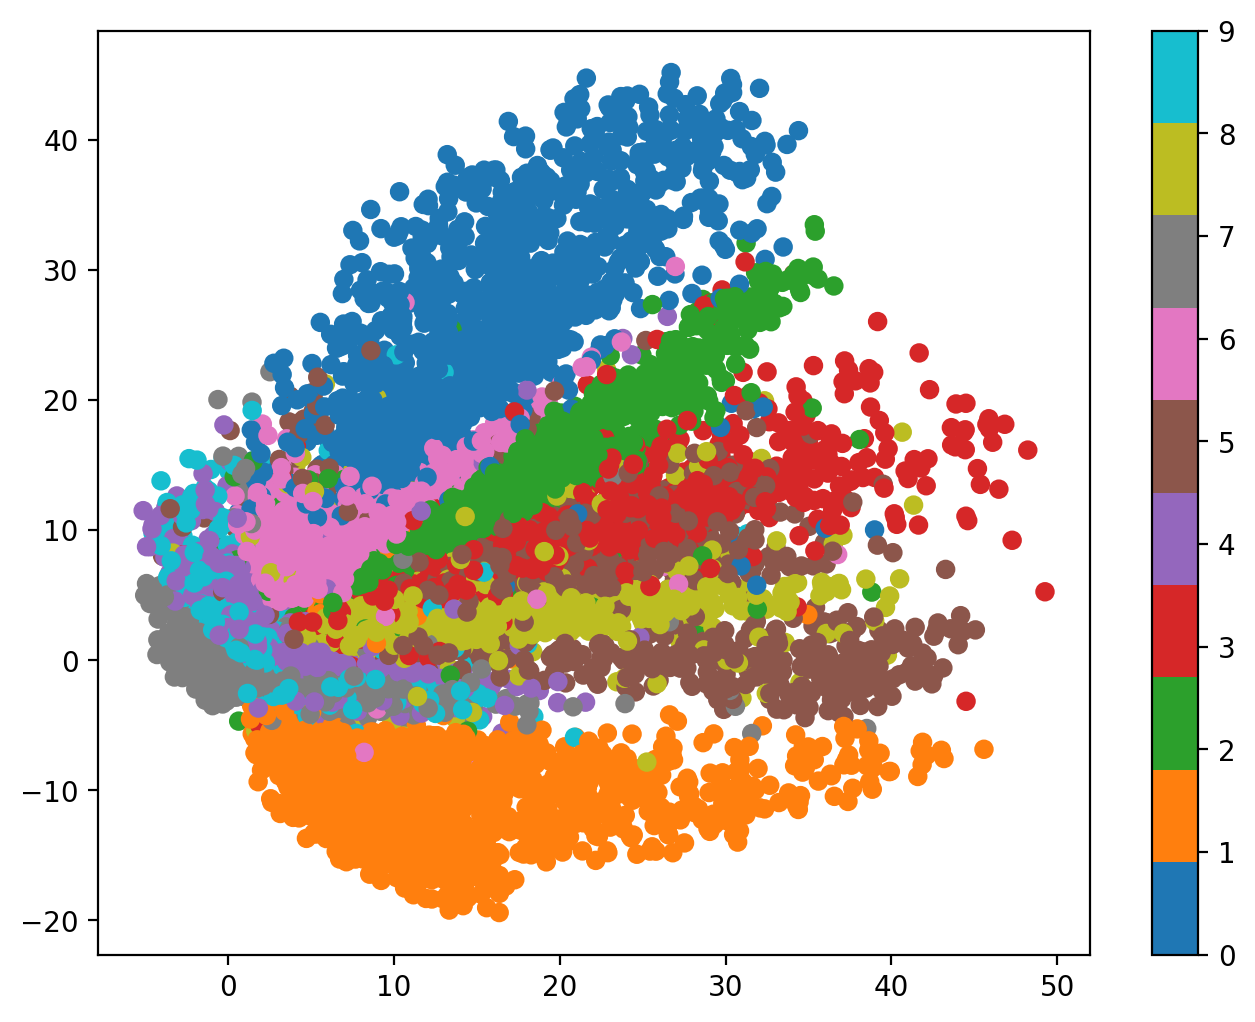

In [113]:
fig = plt.figure(figsize=(8, 6))
plot_latent(vae, data)

In [103]:
def plot_reconstructed(autoencoder, r0=(10, 30), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-i)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

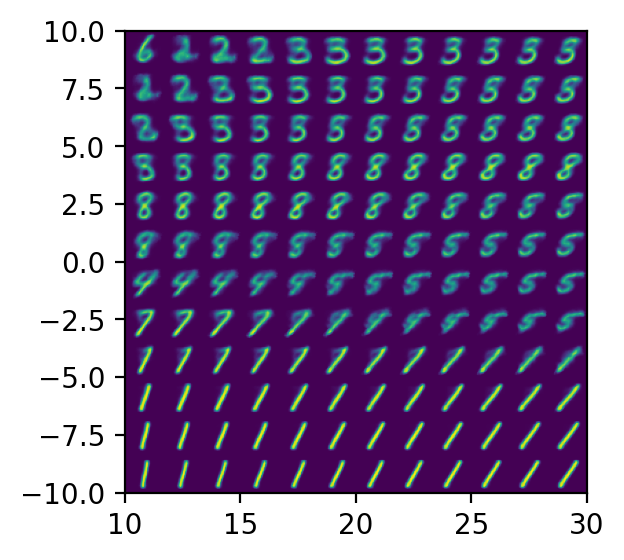

In [104]:
plot_reconstructed(vae)

In [140]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_mu, z_log_var = autoencoder.encoder(x_1.to(device))
    #z = autoencoder.reparametrize(z_mu,z_log_var)
    z_sigma = torch.exp(0.5*z_log_var)
    z_1 = z_mu + z_sigma*autoencoder.N.sample(z_mu.shape)

    z_mu, z_log_var = autoencoder.encoder(x_2.to(device))
    #z = autoencoder.reparametrize(z_mu,z_log_var)
    z_sigma = torch.exp(0.5*z_log_var)
    z_2 = z_mu + z_sigma*autoencoder.N.sample(z_mu.shape)
    
    # Generates n points lying on line joining z_1 and z_2
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

In [ ]:
interpolate(vae, x_1, x_2, n=20)

In [ ]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_mu, z_log_var = autoencoder.encoder(x_1.to(device))
    #z = autoencoder.reparametrize(z_mu,z_log_var)
    z_sigma = torch.exp(0.5*z_log_var)
    z_1 = z_mu + z_sigma*autoencoder.N.sample(z_mu.shape)

    z_mu, z_log_var = autoencoder.encoder(x_2.to(device))
    #z = autoencoder.reparametrize(z_mu,z_log_var)
    z_sigma = torch.exp(0.5*z_log_var)
    z_2 = z_mu + z_sigma*autoencoder.N.sample(z_mu.shape)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [ ]:
interpolate_gif(vae, "vae", x_1, x_2)